In [37]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

import cufflinks as cf
import pandas as pd
import numpy as np
py.offline.init_notebook_mode(connected=True)
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
# print(cf.__version__)

np.random.seed(seed=42) 

In [52]:
raw = pd.read_csv("data/sloan14.csv", sep=',')
raw_data = raw.drop(columns=["objid", "rerun", "fiberid", "specobjid"])

In [53]:
raw_data.head()

,ra,dec,u,g,r,i,z,run,camcol,field,class,redshift,plate,mjd
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,4,267,STAR,-0.000009,3306,54922
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,4,267,STAR,-0.000055,323,51615
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,4,268,GALAXY,0.123111,287,52023
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,4,269,STAR,-0.000111,3306,54922
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,4,269,STAR,0.000590,3306,54922


In [54]:
raw_data.describe()

,ra,dec,u,g,r,i,z,run,camcol,field,redshift,plate,mjd
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,3.648700,302.380100,0.143726,1460.986400,52943.533300
std,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,1.666183,162.577763,0.388774,1788.778371,1511.150651
min,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,1.000000,11.000000,-0.004136,266.000000,51578.000000
25%,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,2.000000,184.000000,0.000081,301.000000,51900.000000
50%,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,4.000000,299.000000,0.042591,441.000000,51997.000000
75%,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,5.000000,414.000000,0.092579,2559.000000,54468.000000
max,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,6.000000,768.000000,5.353854,8410.000000,57481.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a060550>,
      dtype=object)

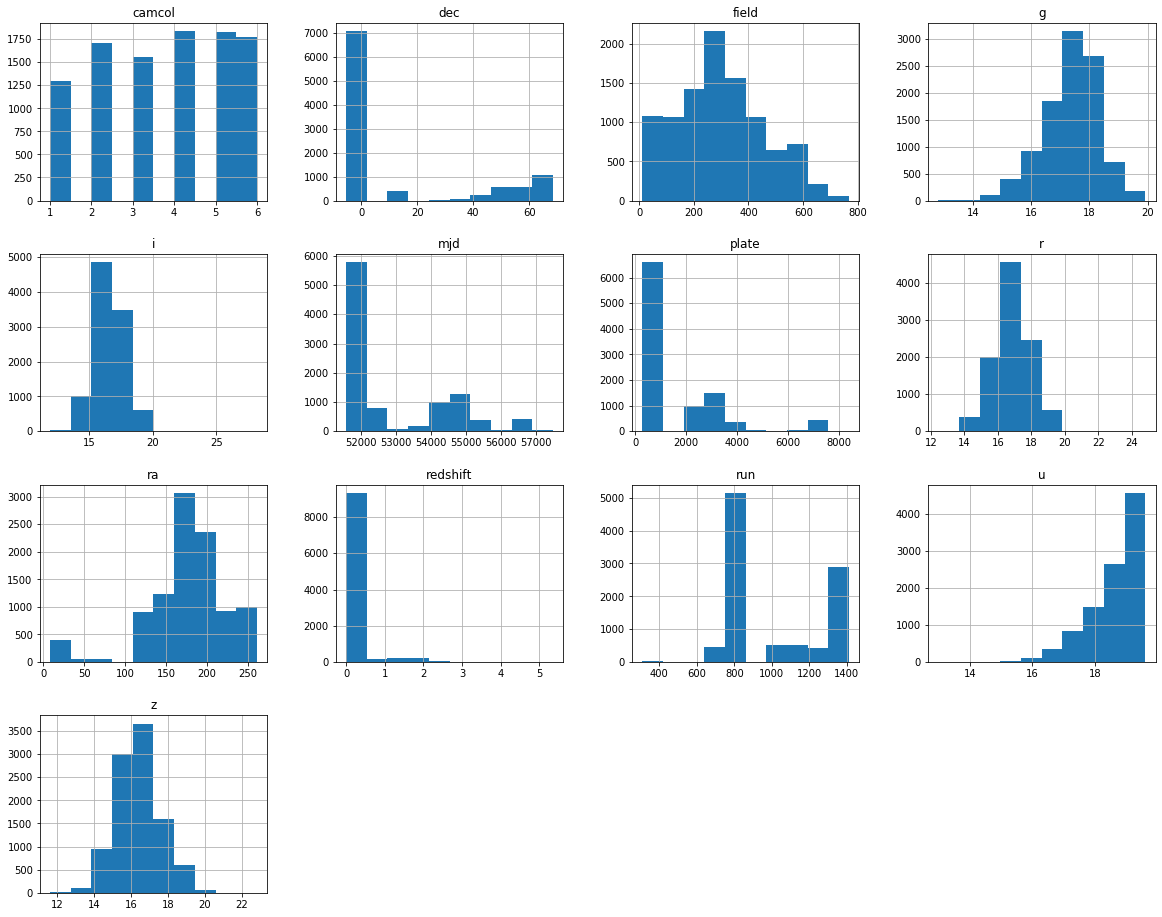

In [55]:
raw_data.hist(figsize=(20,16))

In [64]:
raw_labels = raw_data["class"]
min_class_size = len(raw_labels[raw_labels=="QSO"])

In [90]:
# data["i"].astype(int)

In [127]:
new_data = pd.DataFrame(columns=raw_data.columns)

for labl in ["GALAXY", "STAR", "QSO"]:
    _labels = raw_labels[ raw_labels == labl]
    
    size = min_class_size
    if labl == "STAR": size *=2 # To balance final binary classes 
    
    rand_selected = _labels.sample(n=size, replace=False, random_state=42).index
    _data = raw_data.reindex(rand_selected)
    new_data = new_data.append(_data)

    
labels = new_data["class"].copy()
labels[labels == "GALAXY"] = 1
labels[labels == "STAR"] = 0
labels[labels == "QSO"] = 1
labels = labels.astype(np.int8)

data = new_data.drop(columns=["class"])
data.head()

,ra,dec,u,g,r,i,z,run,camcol,field,redshift,plate,mjd
257,206.044712,-0.761242,19.17263,18.06068,17.63050,17.33272,17.22040,752,2,417,0.086853,299,51671
5010,172.448139,67.894859,18.84141,17.57142,17.09964,16.85146,16.57346,1350,6,338,0.052329,491,51942
5671,201.600564,1.208363,18.62920,17.75404,17.36377,17.02357,16.94105,1404,6,18,0.111805,527,52342
9985,130.766303,51.325652,17.12925,15.53226,14.74467,14.31073,13.90751,1345,3,159,0.030481,445,51873
9878,208.100622,66.739331,18.32993,16.41507,15.47913,15.02539,14.70058,1350,6,429,0.067526,497,51989


In [128]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [129]:
X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.2)

X_train.index

Int64Index([ 435, 6023, 2206, 4041,  628, 1225, 8423, 4587, 1637, 2474,
            ...
            7891, 7576,  616, 6825, 9426, 9021, 4152, 7496, 5423, 5063],
           dtype='int64', length=2720)

## Training an SVM

In [107]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, grid.best_params_

In [130]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 64.8 ms, sys: 2.4 ms, total: 67.2 ms
Wall time: 65.4 ms
SVM Test Accuracy: 0.991


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [103]:
%time _score = cross_val_score(clf, X=X_train, y=y_train, cv=10)
print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWa

CPU times: user 843 ms, sys: 7.73 ms, total: 850 ms
Wall time: 849 ms
SVM CV Accuracy: 0.914(+/- 0.021)


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [106]:
original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.940
SVM CV Accuracy: 0.937(+/- 0.023)


In [108]:
orig_best_params = {'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}

In [131]:
labels = new_data["class"].copy()
labels[labels == "GALAXY"] = 0
labels[labels == "STAR"] = 1
labels[labels == "QSO"] = 2
labels = labels.astype(np.int8)

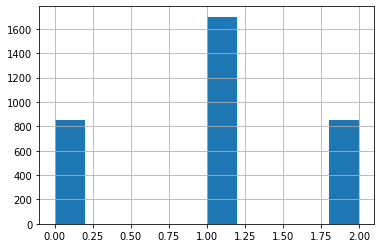

In [132]:
labels.hist()

In [125]:
X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.2)

X_train.index

Int64Index([3485, 2434, 8783,  482,  655, 6668, 1593, 6550, 6736, 6185,
            ...
            2007, 6005, 3432, 1564,  987, 4504,  917, 4712, 4602, 1736],
           dtype='int64', length=2720)

In [126]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 169 ms, sys: 1.84 ms, total: 171 ms
Wall time: 170 ms
SVM Test Accuracy: 0.960


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

